# Maximum area rectangle inside a polygon


Find and draw the maximum area rectangle enclosed in a polygon given as a list of vertices. For your convenience this time we included the code which computes the half-planes that define the polygon.

Your formulation should not involve an exponential number of constraints. 

In [11]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import math
from gurobipy import GRB

In [30]:
vertices = [(0,0), (4,0), (2/3,2+2/3), (-4/3, 2/3)]

vertices = vertices[::-1]
edges = zip(vertices, vertices[1:] + [vertices[0]])
a = []
b = []
for (x1, y1), (x2, y2) in edges:
    # the line ax=b through (x1, y1), (x2, y2) satisfies a*[dx,dy]=0, so a=[-dy,dx] is fine;
    # then b = dx*y1 - dy*x1
    dx = x2 - x1
    dy = y2 - y1
    a.append((-dy,dx))
    b.append(dx*y1 - dy*x1)

In [31]:
n = len(a)
d = 2  # dimension: in future we will extend the solution for any d, so let's be prepared.
m = gp.Model()
# our rectangle is the set {x in R^d: l <= x <= u}
l = m.addMVar(d,lb=[-GRB.INFINITY]*d)
u = m.addMVar(d,lb=[-GRB.INFINITY]*d)
v = m.addVar() #volume/area
s = m.addMVar(d) #sides
t = m.addMVar((n,d)) #sides

m.addConstrs(sum(t[i][j] for j in range(d))<=b[i] for i in range(n))
m.addConstrs(a[i][j]*u[j] <= t[i][j] for i in range(n) for j in range(d))
m.addConstrs(a[i][j]*l[j] <= t[i][j] for i in range(n) for j in range(d))
m.addConstr(s == u - l)
m.addConstr(s[0]*s[1] >= v*v)

m.setObjective(v, GRB.MAXIMIZE)
m.optimize()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 22 rows, 15 columns and 44 nonzeros
Model fingerprint: 0x7bb9242d
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [7e-01, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
Presolve removed 16 rows and 7 columns
Presolve time: 0.01s
Presolved: 9 rows, 10 columns, 21 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.700e+01
 Factor NZ  : 4.500e+01
 Factor Ops : 2.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Pr

In [32]:
m.ObjVal**d

3.1999984721474823

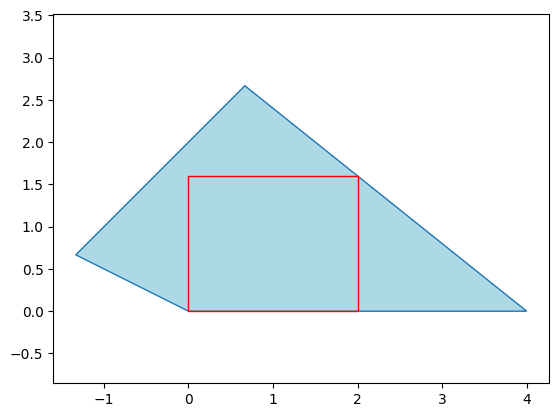

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
xs, ys = zip(*(vertices + [vertices[0]])) #create lists of x and y values

plt.figure()
plt.axis('equal')
plt.fill(xs,ys,facecolor='lightblue', edgecolor='tab:blue', linewidth=1) 
rect = plt.Rectangle((l.X[0], l.X[1]), u.X[0] - l.X[0], u.X[1] - l.X[1], linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.show()
plt.savefig('chebyshev.pdf')

# Part two: Maximum volume rectangle inside a polyhedron


Consider the optimization problem, where we are given a polyhedron $$\mathcal{P} = \{x\,|\,Ax \preceq b\}$$ and we want to find the $d$-dimensional rectangle
  $$\mathcal{R}= \{x\in \mathbf{R}^d \,|\, l \preceq x \preceq u \} $$
of maximum volume, enclosed in $P$. (The variables are $l,u \in \mathbf{R}^d$.)

Formulate this problem as an SOCP program with $O(dm)$ constraints, where $d$ is the number of rows of $A$.

1. Code your program in ``cvxpy`` and solve the problem for the $A$ and $b$ given in the code below. Hint: for the objective function you can use ``cvxpy.geo_mean(x)``. Print the maximum volume. 
2. (for keen programmers) Code your program directly in ``gurobipy`` (or other solver that supports SOCP) and solve the problem for the $A$ and $b$ given in the code below.

In [2]:
m = 70
n = 40
A = np.array([[1.2,- 1.5,0.29,- 1.1,0.47,- 0.53,1.9,- 0.59,0.4,- 0.38,0.73,- 0.49,0.17,0.66,- 0.3,0.43,- 0.17,- 0.74,1.7,- 1.7,0.25,1.1,- 0.49,- 0.033,- 0.5,0.33,- 0.68,0.6,- 0.47,- 1.8,- 0.38,1.3,- 1.2,0.71,0.22,- 0.75,0.65,- 0.64,1.6,0.42],[0.56,- 0.69,1.1,- 0.94,0.64,- 1.6,- 0.32,- 0.032,- 0.43,- 1.7,- 1,- 0.85,- 0.25,- 0.18,1,1,0.13,0.14,- 0.34,0.11,0.5,0.75,- 1.3,- 0.41,- 1.3,0.23,- 1.8,- 0.84,0.95,0.62,0.019,0.44,0.53,- 0.6,0.77,0.72,- 0.93,0.22,- 1.8,- 0.084],[0.34,- 0.022,- 0.33,0.088,1.4,0.82,- 0.25,- 1.7,- 1.5,0.64,- 0.73,- 1.4,- 1.3,- 0.85,- 1.4,- 0.39,0.085,- 1.7,- 1.6,0.76,0.0044,- 1,- 1.4,- 1.5,0.6,- 0.72,- 0.16,- 1.5,0.71,0.61,- 0.12,- 2.2,0.48,- 0.029,0.13,- 0.83,1.6,- 0.13,0.7,0.54],[1.4,0.18,- 0.074,- 0.7,0.043,0.45,- 0.31,0.81,0.66,1.2,0.23,- 0.48,- 0.36,1.6,0.27,- 0.18,- 0.42,- 0.63,0.41,- 0.89,- 0.55,1.8,- 1.3,0.52,0.37,0.014,- 0.63,0.079,- 1.3,- 1,- 0.73,- 0.034,- 1.7,0.95,- 0.39,0.71,0.95,- 0.88,- 0.92,- 1.8],[- 0.49,- 0.53,- 0.16,0.3,- 0.025,- 1.3,2.1,0.5,- 0.27,0.91,- 1.3,- 0.86,- 0.36,- 0.56,- 0.13,2.1,- 0.71,0.29,1,- 0.085,- 1.1,0.24,0.054,0.38,- 0.082,- 0.88,- 0.19,1.2,0.36,0.056,0.95,- 0.16,0.11,0.33,- 0.38,1.3,1.1,- 0.34,1.7,- 0.14],[- 0.067,- 1.3,0.83,- 0.064,- 0.56,0.46,0.47,2.4,- 0.32,- 0.37,1,- 0.41,0.74,- 1.9,- 0.095,1,- 1.8,- 0.78,1.6,0.32,- 1,- 1.9,2.1,- 0.83,0.14,- 1.4,0.46,- 0.21,- 1.3,- 1.4,- 0.39,0.99,0.17,- 0.33,1.6,0.87,- 0.25,- 0.69,- 0.88,- 0.34],[- 1.9,- 0.21,- 2.8,0.64,- 1.1,0.21,- 0.21,0.84,0.56,- 1,- 0.74,- 1.3,0.91,- 0.53,- 0.53,- 0.00074,0.99,2.5,- 1.2,- 0.4,0.21,2.7,0.83,- 0.97,2.4,- 2.2,- 0.96,- 0.077,0.31,0.39,0.9,0.14,0.64,- 1.7,- 0.48,- 0.87,1.1,0.8,- 0.5,- 0.27],[- 0.34,0.34,1.5,- 0.36,- 0.6,0.61,- 1.6,0.71,- 0.27,- 0.38,- 0.066,0.084,0.26,- 0.72,- 0.47,- 1.4,0.69,- 0.3,- 0.43,- 0.53,0.92,- 0.33,1.3,1.5,- 0.86,0.86,- 0.99,- 0.95,- 1.4,- 1.6,- 1.5,0.24,0.85,- 0.53,1.1,0.9,0.27,0.56,1.1,0.077],[- 0.034,- 2.4,0.27,0.25,2,- 0.76,- 0.82,- 1,- 0.21,1.5,0.33,- 0.64,0.86,0.15,0.028,0.31,0.82,- 0.13,1.5,0.76,- 1.2,0.39,1.3,- 0.98,- 2,1.5,- 0.9,- 0.091,- 1,2.8,0.74,0.66,- 0.39,0.51,- 0.37,- 2.5,- 0.68,- 0.28,- 2,1.3],[- 0.44,- 1.5,0.035,0.27,- 0.75,1,- 0.16,- 0.11,0.25,- 0.25,- 0.85,- 0.78,0.24,0.37,- 0.91,0.19,- 0.83,1.7,- 0.82,0.96,0.27,- 0.13,0.4,1.1,0.19,0.13,0.7,- 0.75,- 1.2,- 0.82,- 1.1,1.3,- 1.4,0.13,0.44,- 0.59,1,- 0.18,- 1.9,- 1.2],[- 0.16,- 2.6,0.44,- 1.2,- 1.1,0.85,1.6,- 0.31,- 0.45,- 0.17,0.38,0.73,0.52,0.31,- 1,1.3,0.63,- 0.0079,- 0.94,- 0.3,- 0.51,0.73,0.092,- 1.8,- 0.85,1.5,0.2,0.3,1.2,- 0.52,0.63,- 0.78,0.038,0.074,- 1.6,- 0.59,- 0.36,- 0.39,- 0.0077,- 0.91],[- 1.4,0.74,- 0.98,0.99,1,0.56,0.74,- 0.22,1.1,- 0.2,0.12,0.012,0.87,- 0.088,- 0.61,- 1.6,- 1.9,0.85,- 1.4,0.35,0.39,- 0.22,- 1.3,- 0.14,- 0.83,- 1.5,0.18,0.86,2.2,- 0.7,- 0.35,- 0.72,0.13,- 0.26,2.8,- 0.84,0.15,0.088,- 0.41,- 0.3],[- 0.39,0.3,- 0.2,0.19,- 0.86,0.68,- 1.3,- 1.2,- 0.49,0.9,- 0.28,1.5,- 0.35,0.97,0.62,- 0.36,0.081,- 0.32,0.8,1.7,1.7,- 0.42,- 0.22,1,- 0.18,1.9,0.39,- 1.3,- 1.5,- 0.36,0.12,2.4,- 0.12,0.46,- 1.2,- 0.76,- 0.36,0.51,0.18,- 0.55],[1.6,1.5,- 0.27,0.6,0.19,0.41,- 0.34,0.69,0.88,0.41,- 0.049,- 1.8,- 1.5,0.46,- 0.47,0.65,0.87,1.8,0.084,- 1,- 0.045,- 0.047,- 1.8,- 2.1,- 0.77,- 0.88,- 1.2,1.4,- 0.23,0.39,- 0.38,2.3,- 0.47,- 0.081,- 1.4,- 0.22,1.7,- 0.37,0.19,- 0.58],[- 0.38,- 0.72,- 0.42,1.2,0.11,2.2,- 0.58,- 0.26,0.25,- 0.76,- 0.025,- 0.67,1.4,0.82,- 1.5,1,1.2,- 0.22,0.12,- 1.3,0.52,- 1.6,0.2,- 0.59,0.4,- 0.089,- 1.5,- 0.14,0.54,- 0.2,- 0.75,2.8,0.44,1.5,2.1,0.94,0.77,0.75,- 1.1,1.1],[1.7,- 0.71,0.49,- 0.11,- 0.41,1.9,- 1.1,- 0.01,- 0.26,- 1.3,- 1.3,- 0.72,0.51,- 1.8,1.2,0.18,0.98,1.1,0.49,0.11,- 0.84,1.1,- 1,- 1,- 1.8,- 0.6,- 0.97,- 0.3,- 0.46,- 2,- 0.95,0.42,0.53,- 1.1,- 0.46,0.19,- 0.8,- 1.2,- 0.98,1.7],[1,- 1.9,- 0.4,- 1.6,1,0.75,- 0.17,0.82,2.9,- 0.76,- 0.71,- 0.1,- 0.93,0.92,- 0.96,0.8,0.56,- 0.36,0.73,0.68,- 1,1.1,- 0.84,0.96,0.19,0.7,0.67,1.2,- 1.8,0.11,0.041,- 0.15,- 0.57,2.4,0.057,0.49,- 0.57,1.3,0.59,- 1],[0.063,- 0.29,- 0.14,0.21,- 1.2,- 1.6,1.1,- 0.18,0.95,- 1.3,0.21,- 0.16,- 0.85,- 1.9,0.51,0.32,1.4,- 1.4,- 0.16,0.82,- 0.39,- 1.3,- 0.41,- 1.1,0.76,1.3,- 1.4,- 1.1,0.36,- 0.98,0.13,- 1,- 0.56,0.94,- 1.1,- 2.6,0.28,0.34,1.2,0.13],[- 1,0.019,- 0.1,1.1,- 1.3,- 0.64,1.3,- 0.73,- 1.6,0.72,0.39,0.24,- 1.4,- 0.52,- 0.2,- 1.8,- 1.3,0.67,0.69,- 1.9,- 0.74,- 1.2,- 0.52,- 0.025,0.022,0.097,0.04,3,0.86,- 0.96,- 1.3,1.4,- 1.9,- 1.5,- 0.4,- 0.62,0.49,0.85,- 3.8,- 0.41],[- 1.4,- 0.34,0.2,1.4,- 0.21,- 0.58,0.46,0.33,- 0.027,0.69,- 0.13,0.76,0.98,1,0.27,0.12,- 0.19,0.2,- 0.37,1.1,0.9,- 1.2,0.26,0.6,- 1.7,0.073,- 0.51,- 0.24,1.2,0.75,- 0.2,0.66,- 0.63,- 0.34,- 0.16,- 0.4,1.1,0.64,1.1,- 1.2],[1.4,- 1.8,- 0.12,- 0.26,- 1.3,- 0.45,- 0.96,- 0.17,- 0.88,- 0.18,- 0.94,0.86,0.022,- 0.065,- 1.3,- 0.93,0.47,0.59,- 0.27,0.021,0.92,0.22,- 1,- 0.32,0.12,- 0.49,- 0.65,- 0.1,- 1.3,0.095,1.4,- 0.82,- 0.47,- 0.33,- 0.056,0.54,- 1,- 1.3,- 0.47,1.1],[- 0.66,0.35,- 0.16,1.3,0.81,- 0.17,- 1,0.3,- 0.23,1.3,0.96,- 0.9,0.92,- 0.1,- 0.53,- 0.55,0.33,1.3,- 1.6,- 2.3,- 0.28,- 1.4,- 0.1,- 0.45,0.11,- 0.83,- 1,- 0.47,0.1,0.12,- 0.7,1.9,- 0.61,0.24,1.1,- 1.2,0.41,- 0.67,1,0.18],[- 1.6,- 1.3,- 0.49,0.19,1.2,- 0.42,- 0.23,- 1.3,0.93,0.96,0.62,0.12,- 0.19,0.44,- 0.28,0.5,- 0.46,- 0.34,- 1.2,- 0.42,- 0.028,0.36,- 0.064,- 1.8,- 0.82,0.8,0.9,- 0.8,3.1,0.72,- 0.21,- 0.82,0.49,- 1.2,- 1.8,0.012,- 0.37,0.18,0.5,- 2.7],[0.14,0.77,- 0.52,- 0.06,- 1.2,- 0.63,0.53,- 1.1,- 0.066,- 0.37,- 0.25,- 0.22,- 0.082,- 0.62,- 1.6,0.039,- 0.85,0.3,- 0.3,0.21,- 0.17,0.63,0.7,- 0.79,0.33,1.4,- 1.8,- 0.25,- 0.95,0.15,- 0.69,- 0.49,- 0.3,0.7,- 1.1,- 1.2,- 0.96,- 1.7,- 1.2,0.23],[- 2.6,0.075,- 0.16,- 0.53,- 0.36,- 0.18,0.66,0.47,0.69,- 0.86,- 1.1,- 0.45,0.65,0.25,0.028,0.0015,1.5,0.58,- 1.5,0.43,0.3,- 1.3,0.76,- 1.1,0.61,- 0.28,0.46,- 0.11,1.4,- 0.92,- 0.49,2,1.2,0.77,1.1,0.84,- 0.017,1.4,0.25,- 0.75],[- 0.55,2.5,0.022,0.24,- 1,0.22,2.1,0.96,- 0.49,0.75,0.61,0.87,0.66,0.083,0.36,0.017,0.56,- 0.63,1.7,0.12,- 0.37,0.071,- 1.2,- 0.37,- 0.96,- 1.2,- 0.23,1.2,- 0.87,1.1,0.21,- 1.9,1.9,0.1,0.31,0.69,1.3,0.98,0.38,0.86],[1,1.1,- 1.1,0.82,- 0.76,0.54,- 1.4,- 3,- 0.62,0.74,0.16,- 0.11,1.4,- 0.65,0.39,1.7,- 1.9,0.52,- 2,0.18,- 0.82,- 2.3,2.8,2,0.6,0.09,- 1.5,0.45,2.4,- 0.25,2,2.3,- 0.52,- 0.0025,- 1.9,- 0.76,- 0.29,0.53,- 2.4,- 0.066],[2,1,- 0.046,1.7,1.7,- 1.4,- 0.082,1.3,- 0.2,0.96,- 0.7,0.93,- 0.45,0.54,0.051,1.1,- 0.83,- 1,- 1.4,0.089,- 0.74,0.1,0.26,- 0.5,- 1.2,- 0.044,1.1,- 0.0037,- 1.1,- 0.84,- 1.2,- 1.3,- 1.5,- 1.1,1.6,0.24,1.2,- 1.5,- 0.74,- 1.3],[2.2,1.7,- 0.56,0.94,- 0.46,- 0.24,0.2,- 1.2,- 0.1,0.19,- 0.5,0.069,0.26,0.81,- 0.83,- 0.22,0.76,- 0.1,0.26,0.54,1.7,- 1.6,0.16,- 0.019,0.3,- 0.2,0.83,- 0.57,0.6,0.73,0.54,- 0.11,- 0.52,0.32,0.57,- 0.36,1.3,- 1.4,0.72,- 0.59],[1,1.3,0.4,- 0.0041,0.51,0.36,- 1.7,0.4,1.5,- 0.35,0.0038,0.24,0.12,0.76,0.84,0.75,- 1.2,- 0.31,0.18,- 1.9,- 0.58,- 1.2,3.8,0.073,- 1.2,- 0.52,- 0.56,0.12,- 0.028,1.2,- 1.4,- 0.42,0.65,- 1.3,- 0.57,- 0.3,2,0.32,1,- 0.051],[- 0.16,- 0.9,0.32,0.66,- 1.2,- 0.67,- 0.53,0.77,- 1.6,- 0.62,0.4,- 0.33,- 1.4,- 0.21,- 0.86,- 0.19,- 0.35,- 1.1,- 0.24,0.88,- 0.85,- 0.57,0.95,- 1.1,0.19,- 0.45,- 0.95,0.34,2.3,0.25,- 2,0.0073,- 0.83,- 0.25,0.058,0.49,0.58,- 0.34,0.18,- 0.83],[1.1,0.66,0.18,- 0.3,- 0.35,- 0.92,0.69,0.63,1.3,1,- 0.11,0.23,- 0.53,0.97,0.65,- 0.57,- 1.8,2.5,1.8,- 0.2,- 0.4,0.66,0.25,0.11,- 2.2,0.15,- 0.34,- 0.51,0.96,0.84,1,- 1.9,- 0.22,- 0.35,0.4,0.76,- 0.27,0.17,- 0.15,0.83],[0.13,0.075,- 0.7,- 1.1,- 0.072,1.1,0.037,0.23,- 0.0054,- 1.3,- 0.55,1.3,- 1.7,- 0.026,- 2.2,- 0.65,- 1.1,2,0.58,0.63,0.72,0.16,- 0.18,2.1,- 0.43,- 0.97,0.62,0.28,1.3,0.1,2.3,- 0.073,- 0.3,- 3.1,- 1.3,0.37,2,1.4,- 2.2,0.77],[- 0.018,0.19,0.66,0.0003,0.63,- 1.5,- 0.56,0.31,- 0.28,- 0.048,0.7,1.2,0.15,- 0.41,1.1,- 0.88,- 0.66,0.71,- 0.55,0.83,2.2,0.64,- 0.25,1.2,0.88,0.24,0.93,- 0.91,- 1,- 0.27,- 0.41,2.2,0.36,1.2,0.076,0.39,- 0.59,- 0.46,- 0.54,0.99],[0.43,- 0.52,- 0.12,- 0.15,0.45,- 0.34,1.2,0.25,- 0.68,0.97,- 0.84,2.3,2,1.1,- 1.3,- 0.77,0.65,1.5,- 0.6,1,0.38,- 0.76,- 0.014,3,- 2,0.82,- 0.068,0.67,1.1,- 1.3,0.27,- 0.83,- 2.1,- 0.6,- 0.99,- 1.4,0.79,0.22,0.13,1.3],[- 1.4,1,- 0.49,0.21,0.18,- 0.87,- 0.55,0.012,- 1,1.8,- 0.47,0.71,0.46,- 0.31,1,- 2,0.5,- 0.19,0.36,- 0.42,1.5,- 0.91,- 1.3,0.45,1.9,- 0.1,- 0.11,- 0.92,0.89,0.64,0.17,0.89,- 0.17,- 0.17,- 1.2,1.1,0.6,0.99,0.28,0.14],[1.7,0.94,1.4,1.7,- 1,- 1.8,- 1.5,1.5,1,- 0.6,0.27,- 0.27,- 0.77,0.31,0.34,1.4,- 0.36,- 2,1.2,1.5,- 1.5,- 0.2,0.29,- 0.47,- 0.27,0.018,1.2,1.1,- 2.1,- 1.4,- 0.83,- 0.28,0.48,0.25,1.2,- 1.3,- 0.31,0.41,0.059,2.2],[0.66,- 1.1,0.63,- 1.7,- 0.38,1.2,- 0.87,1,- 0.52,- 0.84,- 0.19,- 0.58,1,0.36,- 0.27,- 0.16,0.97,- 1.1,- 0.89,- 1.1,- 0.67,0.33,0.42,1.5,0.15,0.21,1.1,- 1.9,- 0.2,- 1.9,1.4,0.031,- 1.5,- 0.4,- 0.57,- 0.9,- 0.68,0.1,- 1.3,1],[- 0.71,- 0.65,0.12,1.1,1,- 0.39,1.2,0.18,- 0.23,- 0.22,- 0.72,0.044,0.17,1.8,- 1.2,- 0.17,- 0.55,- 0.5,0.16,0.17,0.71,0.49,0.59,0.6,- 0.77,- 0.57,1.1,- 0.76,0.52,- 2.5,0.69,0.97,1.5,1.3,- 0.0059,- 0.01,- 0.36,- 1.1,2.3,- 1.5],[1.6,1.7,0.76,- 1.5,0.42,0.3,- 0.66,0.27,- 0.065,1.6,- 0.77,1.2,- 0.093,- 1.1,0.68,- 0.89,0.16,2.2,- 1.6,0.58,- 1.7,1.1,0.29,0.15,0.35,0.076,0.66,- 1.1,- 0.19,- 0.75,- 0.23,2.7,- 0.83,- 0.74,1.3,0.13,- 0.42,- 0.029,0.59,0.013],[- 2,0.28,- 1.3,0.17,0.062,- 0.099,0.66,- 0.87,0.49,0.087,1.6,- 0.25,1.2,0.059,- 0.19,0.32,0.41,0.21,- 1.1,- 0.55,- 0.69,- 1.4,1.4,1,0.35,- 0.27,0.42,0.11,- 1.4,- 0.88,- 0.44,2.7,0.56,0.29,- 0.34,2,- 0.65,1.3,- 0.35,- 0.76],[0.81,- 0.083,- 0.098,- 0.37,0.45,- 0.81,- 0.22,- 1.6,1,0.029,- 1.3,0.12,1.9,- 0.27,- 1.4,0.71,0.0037,- 0.42,- 0.7,- 0.76,- 0.27,- 0.72,0.34,0.96,0.36,0.58,- 1.7,- 1.3,0.42,0.26,- 0.66,- 2.9,- 1.8,- 0.92,- 0.68,0.72,1.2,0.98,0.64,0.078],[0.24,0.37,- 0.32,0.57,0.55,0.74,0.74,1.2,0.28,0.37,- 1.2,0.32,- 0.6,0.89,1.3,- 0.63,- 0.84,2.2,0.15,0.98,0.65,0.31,- 0.92,- 0.25,- 1.8,- 0.28,- 0.3,0.81,0.95,- 2,1.1,0.93,- 2.1,- 0.88,- 0.21,- 0.39,- 0.0034,- 0.04,0.8,0.23],[0.32,- 0.81,- 1.7,0.51,0.44,1,0.65,0.49,- 1.6,- 0.16,0.59,- 0.31,- 0.85,0.32,1.2,0.3,- 0.8,- 0.17,0.3,- 1.6,- 0.34,- 0.43,- 1.2,1.2,- 1.2,- 0.33,1,1.9,1.7,0.55,- 2.4,- 1.7,0.56,- 0.2,0.81,1.3,- 1.3,1,- 0.57,0.72],[0.52,1.9,0.38,0.47,0.28,0.8,0.039,0.28,- 1.2,- 1,1.8,- 0.7,- 1.1,- 0.47,0.98,- 0.73,1,- 0.37,- 0.78,- 0.88,0.34,- 1.4,- 0.74,0.47,1.2,0.12,0.53,0.79,- 0.93,1.6,1.9,- 1.8,- 0.16,2.1,0.2,- 1.6,- 0.54,- 0.98,0.15,0.75],[0.15,1.9,0.12,0.67,0.25,0.63,0.58,0.071,- 0.09,- 0.099,- 0.13,- 0.1,0.14,1.2,- 1.4,- 2.6,- 1.3,0.5,0.52,0.2,1.6,- 0.31,0.5,0.2,0.72,- 1.6,0.38,- 0.38,- 0.15,0.31,1.3,0.82,0.059,1.3,0.29,0.37,- 1.2,- 0.94,0.84,0.036],[- 0.43,- 2.5,- 0.45,- 1.6,0.87,- 2.3,- 0.36,0.27,- 4.1,- 0.93,- 2.3,1.3,- 1.5,- 1.3,0.5,1.7,1.3,0.15,1.1,0.19,- 0.48,0.52,0.46,0.69,0.32,- 1.2,- 0.72,- 1.9,- 0.23,- 0.49,0.81,- 0.97,- 0.0034,- 0.036,1.1,- 0.22,0.56,0.6,- 0.44,0.93],[0.68,- 0.4,- 0.71,- 1.7,- 0.6,- 0.24,0.61,- 1.1,- 0.21,0.37,0.047,- 2.2,0.33,0.13,0.18,- 0.95,0.079,- 1,- 0.14,- 0.73,0.18,- 0.22,1.6,0.47,1.3,- 0.94,- 1.1,- 0.69,1.6,- 0.84,- 0.12,0.22,- 0.68,- 0.096,0.4,- 0.22,0.93,- 1,- 0.57,0.42],[0.84,0.11,0.47,0.0061,- 0.073,- 0.81,1.1,- 0.26,- 0.37,1.5,- 1.9,0.0028,- 1.1,0.85,0.52,- 0.4,- 0.05,0.71,0.17,1.7,0.28,0.0051,0.85,- 0.39,- 2.1,- 0.34,- 0.58,0.29,- 2.8,0.22,0.16,- 0.39,- 0.77,- 0.043,2.2,0.065,1.5,- 1.5,0.35,0.23],[0.24,0.52,- 1.9,- 0.43,- 0.76,0.38,- 0.55,- 0.74,- 0.28,- 0.57,- 1.1,- 0.7,1.1,1,- 1.2,- 0.076,0.95,0.39,0.012,- 1.3,0.56,- 1.2,- 1.6,- 0.37,2.4,- 0.93,- 1.1,- 1.1,0.3,0.47,- 1.1,- 0.8,0.32,- 0.54,0.16,0.54,- 0.71,0.57,0.39,- 0.068],[0.32,- 0.59,- 0.24,- 0.83,- 1.2,- 0.19,- 0.69,0.6,0.86,- 1.1,- 0.51,2.3,- 0.95,1.2,- 0.86,0.9,- 1.6,1,- 1.1,0.13,- 0.59,2.1,0.95,- 1.5,0.41,0.55,0.12,0.43,- 2.1,- 0.59,- 2.4,1.1,0.79,- 0.49,1.3,- 0.26,0.14,- 1.3,- 0.55,- 0.36],[0.73,- 1.1,- 0.71,0.11,- 1.7,- 0.58,- 0.45,- 0.41,- 0.42,1.2,- 1.9,- 0.64,- 1.6,- 0.4,0.69,- 0.87,- 0.33,0.86,1.4,- 0.69,- 1.3,- 1.3,0.84,- 1.7,- 0.25,0.21,- 1.4,- 0.14,- 0.4,- 1.7,0.43,- 1.5,0.72,- 0.19,0.26,- 0.91,- 0.96,- 0.08,- 1.3,- 0.17],[0.099,- 1.2,0.23,0.44,- 0.41,0.14,0.74,- 1.9,0.8,0.74,1.7,- 0.31,- 0.96,0.4,0.81,2.6,- 2.5,- 0.58,1,- 0.47,- 0.13,0.37,- 1.1,- 0.28,- 0.13,- 0.044,1.6,- 0.13,- 0.26,- 1.1,0.29,0.22,0.21,1,0.56,- 1.6,- 0.28,2.2,- 0.23,- 0.56],[0.056,0.087,0.098,- 0.078,- 1.6,- 0.59,- 2.4,- 0.21,1.8,0.93,1.3,- 0.81,- 0.65,- 1.5,0.59,- 0.51,- 0.66,0.22,0.28,- 0.24,0.69,0.27,- 1.3,- 0.89,- 0.64,- 0.36,- 0.2,0.054,0.59,- 0.35,- 1.1,- 0.082,1.2,0.3,0.18,0.06,1.6,1.3,0.41,- 0.4],[- 0.61,0.2,0.044,- 0.26,0.33,0.73,- 0.74,- 0.96,0.35,0.48,- 1.8,- 0.77,1.7,0.63,0.38,- 0.16,- 1.9,0.61,0.19,- 1.2,- 1,0.041,0.45,1.2,1.7,- 0.67,- 0.89,0.39,- 1.9,- 1.4,- 0.58,0.14,1.7,0.095,0.6,- 0.13,0.53,- 0.2,- 0.82,0.37],[- 0.27,1.7,- 0.55,0.96,0.28,- 0.8,1.9,0.81,- 1,- 0.84,1.4,1.3,- 0.074,- 0.89,3.1,- 0.76,0.2,- 1.1,- 0.11,0.54,0.23,- 0.15,- 1.9,1.9,- 0.1,1.3,- 2.3,- 1.2,0.15,0.34,3,1.5,- 0.41,- 0.75,1.5,- 2.5,0.82,- 0.75,0.26,- 0.035],[- 0.031,0.71,1.9,0.86,- 0.26,- 1.1,0.58,- 2.1,1.4,1.8,- 1.4,- 1.9,- 0.98,0.068,- 0.024,- 0.49,- 1.6,- 1.4,1.1,0.96,1.7,0.67,- 0.89,- 1.3,0.71,1.2,0.2,0.15,- 0.56,1.4,- 0.88,- 0.57,- 1.4,0.76,1,- 0.02,- 0.67,- 1,0.94,0.25],[- 1.3,0.012,0.18,1.7,0.86,0.17,- 0.064,0.27,0.058,0.2,- 0.73,- 0.1,- 0.43,0.15,- 0.12,2.1,0.26,1,2.6,- 0.16,0.76,- 1.1,- 1.4,0.69,- 0.56,- 0.26,1.5,0.063,- 0.7,0.59,0.62,- 0.84,0.74,1.5,- 0.66,- 1.8,1.4,0.53,- 0.92,0.44],[1.4,1.6,- 0.86,0.71,- 0.0056,- 2,0.39,1.5,0.55,1.2,- 0.61,- 1.3,0.99,- 0.045,1.8,0.85,0.26,0.039,- 1.5,- 0.69,- 0.29,0.98,0.27,- 0.23,1.3,0.46,1.1,- 0.47,- 1.1,0.42,0.58,0.71,1,- 0.28,1.5,- 1.8,- 0.77,- 0.2,0.74,- 0.58],[0.54,- 1.1,- 1,0.5,1.3,1.1,0.03,- 0.93,1.1,0.91,- 1.3,- 0.016,2.2,- 0.45,- 0.85,- 0.82,0.4,1.1,0.47,- 0.46,0.5,0.4,- 1.5,0.86,- 1.4,- 0.39,- 1.9,0.64,- 0.6,0.013,0.71,2.1,- 1.4,- 0.57,- 0.41,- 0.034,- 2.5,0.35,- 0.2,0.15],[0.032,0.41,- 0.34,- 1.1,- 0.8,0.26,- 1,1,- 1.5,0.1,0.2,1.1,1.6,- 0.62,0.66,- 0.4,- 1.2,0.055,- 0.16,- 0.28,2.1,1.5,- 0.3,1,- 0.5,0.24,0.7,1,0.064,- 1,0.65,- 0.69,0.87,0.44,0.063,0.23,0.44,- 0.55,- 1.1,- 0.46],[- 0.88,0.3,- 1.4,- 0.015,0.53,0.39,2.7,- 0.82,2.2,- 0.017,2.2,- 0.87,0.82,- 0.43,- 1.4,0.63,0.22,0.24,- 0.91,0.53,0.45,- 0.01,1.3,1.2,- 0.28,- 0.21,1.1,0.14,- 0.86,- 0.93,1.5,- 1.1,- 0.73,0.4,- 0.86,0.23,- 0.89,1.3,0.31,- 0.5],[1.8,0.85,- 0.32,1.3,- 0.24,0.16,0.22,0.6,0.25,1.2,- 0.26,- 2.2,0.06,0.71,0.27,- 0.16,- 0.83,0.7,0.45,1.6,- 0.44,1.6,- 0.18,- 0.28,- 1.6,1.6,1.4,0.16,- 1.4,0.61,- 0.64,0.27,1.5,0.42,1.8,0.4,- 1.2,- 0.046,- 0.99,0.65],[1.5,0.9,- 2.1,- 0.58,0.6,- 1.1,- 2.6,0.44,- 0.21,- 0.44,1.8,0.092,0.53,- 0.85,1.9,1.4,- 0.6,- 1.4,0.31,0.43,- 1.5,0.35,- 0.87,- 0.4,- 0.49,- 1.6,1.8,- 1.5,- 1.5,- 1.9,2.1,1.4,0.63,1.3,1.6,- 2.3,- 0.27,- 0.55,1.1,0.13],[0.42,1.8,0.92,- 0.59,- 1.9,0.034,- 1.9,0.95,- 1.1,0.97,1.2,- 1.4,- 0.74,0.5,1.3,- 0.66,1,0.44,0.87,1.8,- 0.42,- 0.11,0.65,0.71,- 0.021,0.078,- 1,- 0.34,1.1,- 0.32,- 2,- 0.36,- 0.44,0.041,- 0.37,0.59,- 0.34,0.41,0.7,1.7],[- 0.45,- 0.051,- 0.74,0.35,0.69,- 1.1,0.12,0.3,1.5,- 0.12,1.3,1.6,- 1.2,- 0.41,- 0.31,- 0.099,- 0.14,- 1.3,0.43,- 0.72,- 0.52,0.49,0.24,- 0.89,- 0.59,- 0.64,- 0.65,0.33,0.037,0.52,1.1,- 0.62,- 0.57,- 0.036,0.79,- 2.6,0.72,- 0.0043,0.82,- 1],[1.2,1.6,0.51,- 0.11,0.67,- 0.58,0.32,0.23,- 0.35,- 1.2,0.72,1.8,0.81,0.83,- 0.11,0.67,0.41,0.038,1.1,1.2,0.65,0.047,- 0.32,- 0.1,1.9,2.4,0.69,- 2.2,- 0.91,- 0.68,2.4,0.99,- 0.29,- 0.33,0.92,- 0.53,- 0.6,- 0.034,0.3,1.1],[- 0.29,0.1,- 0.17,- 1.3,- 1,- 0.42,0.52,- 0.75,1.4,2,- 1.3,- 1.8,0.72,1.9,0.0061,0.12,0.67,- 1.7,0.3,0.14,- 0.15,0.9,- 0.51,- 0.56,- 0.055,0.57,0.86,- 1.9,- 0.01,- 0.16,- 0.45,0.68,- 1.1,- 1,0.19,- 1.2,- 0.85,0.18,- 1.3,- 0.67],[3.8,1.3,0.062,- 1.6,0.59,0.21,0.78,1.9,0.6,- 0.12,- 0.39,- 0.17,1.2,- 1,1.2,0.064,- 1.3,0.13,- 0.081,0.09,0.32,- 1.4,0.056,- 0.5,0.12,0.36,0.58,- 0.067,1.1,- 0.6,1,- 2.2,- 1.6,- 0.0027,0.33,- 0.83,0.42,- 1.1,0.32,- 0.75],[- 0.48,1.6,- 0.47,- 1.2,0.29,1.6,- 0.16,- 0.35,- 1.3,- 0.51,- 0.51,- 0.84,0.56,0.62,0.68,- 0.11,- 0.14,0.44,0.039,- 0.41,- 0.73,- 0.97,- 0.38,- 0.27,- 0.41,- 0.54,0.48,- 0.75,- 0.97,0.01,- 1.2,- 0.26,0.83,- 1.7,0.0063,- 0.87,- 2.3,0.61,2.1,0.57]])
b = np.array([[490.0],[230.0],[140.0],[600.0],[210.0],[29],[830.0],[140.0],[14],[200.0],[68],[590.0],[170.0],[700.0],[170.0],[730.0],[460.0],[27],[430.0],[600.0],[600.0],[290.0],[690.0],[62],[1100.0],[230.0],[430.0],[860.0],[950.0],[440.0],[68],[480.0],[55],[7.5],[180.0],[600.0],[750.0],[290.0],[300.0],[660.0],[870.0],[350.0],[100.0],[140.0],[220.0],[66],[180.0],[290.0],[360.0],[100.0],[130.0],[310.0],[43],[23],[260.0],[120.0],[13],[560.0],[590.0],[230.0],[14],[380.0],[770.0],[620.0],[180.0],[200.0],[510.0],[120.0],[1600.0],[210.0]])
b = b/20.0
print(A.shape)
print(b.shape)

(70, 40)
(70, 1)


# Solultion

The rectange lies inside the polyhedron when for every constraint $i$:

$$\sup_{l \preceq x \preceq u}a_i^T x \le b_i$$

This is a convex constraint ($\sup_y f(x,y)$ is convex when $f$ is convex for every $y$.)
We will show that the above constraint can be phrased using two LP constraints. Indeed, it is equivalent to

$$\sum_{j=1}^n\sup_{l_j \le x_j \le u_j} a_{ij} x_j \le b_i$$

A linear function defined on an interval has its maxima on the ends of the integral, hence we get

$$\sum_{j=1}^n\max(a_{ij} u_j,a_{ij} l_j) \le b_i$$

The above is equivalent to two linear constraints in a stadard way (no need to expand it using ``cvxpy``).

In [ ]:
import cvxpy as cp

In [3]:
u = cp.Variable(n)
l = cp.Variable(n)
obj = cp.Maximize(cp.geo_mean(u-l))
#constraints = [sum(cp.maximum(A[i,j],0)*u[j]-cp.maximum(-A[i,j],0)*l[j] for j in range(n)) <= bb[i] for i in range(m)]
#constraints = [sum(cp.maximum(A[i,j]*l[j],A[i,j]*u[j]) for j in range(n)) <= bb[i] for i in range(m)]
constraints = [cp.reshape(sum(cp.maximum(A[:,j]*l[j],A[:,j]*u[j]) for j in range(n)),(m,1)) <= b] + [l<=u]
prob = cp.Problem(obj,constraints)
prob.solve(verbose=True,solver=cp.GUROBI)

                                     CVXPY                                     
                                     v1.2.3                                    
(CVXPY) Jan 29 12:55:06 PM: Your problem has 80 variables, 2 constraints, and 0 parameters.
(CVXPY) Jan 29 12:55:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 29 12:55:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 29 12:55:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 29 12:55:06 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jan 29 12:55:06 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Co

1.1137783258238874

In [4]:
prob.value**n

74.46470782831192

In [5]:
for _ in range(10000):
    v = np.random.randint(2, size=n)
    x = np.array([[u[i].value if v[i]==0 else l[i].value for i in range(n)]]).T
    if not all(A@x<=b):
        print("Wrong solution")